# Fall Detection using SisFall Dataset
Daniela Dias, nMec 98039

In [67]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Utility functions for SisFall dataset

**ADXL345**
Resolution: 13 bits
Range: +-16g

**ITG3200**
Resolution: 16 bits
Range: +-2000?s

**MMA8451Q**
Resolution: 14 bits
Range: +-8g

In [68]:
ACCEL_ADXL345_RANGE = 16  # ±16g
ACCEL_ADXL345_RES = 13

GYRO_ITG3200_RANGE = 2000  # ±2000°/s
GYRO_ITG3200_RES = 16

ACCEL_MMA8451Q_RANGE = 8  # ±8g
ACCEL_MMA8451Q_RES = 14

In [69]:
# Accelerometer conversion functions
def convert_accel_adxl345(raw_bits):
    return (2 * ACCEL_ADXL345_RANGE / (2 ** ACCEL_ADXL345_RES)) * raw_bits


def convert_accel_mma8451q(raw_bits):
    return (2 * ACCEL_MMA8451Q_RANGE / (2 ** ACCEL_MMA8451Q_RES)) * raw_bits

In [70]:
# Gyroscope conversion function
def convert_gyro_itg3200(raw_bits):
    return (2 * GYRO_ITG3200_RANGE / (2 ** GYRO_ITG3200_RES)) * raw_bits

In [71]:
# Labeling function
def get_label_from_filename(filename):
    if filename.startswith('F'):
        return 'fall'
    elif filename.startswith('D'):
        return 'adl'
    else:
        return 'unknown'

## Load SisFall dataset

The SisFall dataset consists of time-series data from three sensors: ADXL345 accelerometer, ITG3200 gyroscope, and MMA8451Q accelerometer. The data is recorded in text files, with each file containing multiple lines of sensor readings. Each line represents a single sample with the following format:
    
*<accel_adxl345_x>,<accel_adxl345_y>,<accel_adxl345_z>,
<gyro_itg3200_x>,<gyro_itg3200_y>,<gyro_itg3200_z>,
<accel_mma8451q_x>,<accel_mma8451q_y>,<accel_mma8451q_z>;*

The dataset is organized into folders for each subject, with each folder containing multiple text files. The filenames indicate the type of activity (fall or activities of daily living), the subject ID and the trial. We treat each trial as an independent sample.


The following code loads the SisFall dataset, converts the raw sensor data into numerical features, and labels the samples based on the filenames. The dataset is then saved as a CSV file for further analysis.

In [72]:
# Load single file
def load_sisfall_file(filepath):
    raw_data = pd.read_csv(filepath, header=None, sep=',')

    # Remove trailing semicolon from each element
    raw_data = raw_data.map(lambda x: float(x.rstrip(';')) if isinstance(x, str) else x)

    data_converted = pd.DataFrame({
        'accel_adxl345_x': convert_accel_adxl345(raw_data[0]),
        'accel_adxl345_y': convert_accel_adxl345(raw_data[1]),
        'accel_adxl345_z': convert_accel_adxl345(raw_data[2]),

        'gyro_itg3200_x': convert_gyro_itg3200(raw_data[3]),
        'gyro_itg3200_y': convert_gyro_itg3200(raw_data[4]),
        'gyro_itg3200_z': convert_gyro_itg3200(raw_data[5]),

        'accel_mma8451q_x': convert_accel_mma8451q(raw_data[6]),
        'accel_mma8451q_y': convert_accel_mma8451q(raw_data[7]),
        'accel_mma8451q_z': convert_accel_mma8451q(raw_data[8])
    })

    label = get_label_from_filename(os.path.basename(filepath))
    data_converted['label'] = label

    return data_converted

In [73]:
# Load entire dataset
def load_sisfall_dataset(dataset_dir):
    dataset = []

    for subject_folder in os.listdir(dataset_dir):
        subject_path = os.path.join(dataset_dir, subject_folder)

        if os.path.isdir(subject_path):
            for file in os.listdir(subject_path):
                if (file.endswith('.txt')
                        and (file.startswith('F') or file.startswith('D'))):
                    # Load the file and convert the data
                    filepath = os.path.join(subject_path, file)
                    file_data = load_sisfall_file(filepath)

                    # Add filename and subject information
                    file_data['filename'] = file
                    file_data['subject'] = subject_folder

                    dataset.append(file_data)

    # Convert the list of DataFrames to a single DataFrame
    full_dataset = pd.concat(dataset, ignore_index=True)

    return full_dataset

In [74]:
# Load the SisFall dataset
dataset_dir = 'SisFall_dataset'
sisfall_data = load_sisfall_dataset(dataset_dir)

# Save the dataset to a CSV file
# sisfall_data.to_csv('sisfall_dataset.csv', index=False)

In [75]:
# Load the SisFall dataset from the CSV file
# sisfall_data = pd.read_csv('sisfall_dataset.csv')

## Exploratory Data Analysis

This section provides an overview of the dataset, including its structure, distribution of labels, and basic statistics. It also visualizes the sensor data to understand its characteristics better.

In [76]:
# Check the first few rows of the dataset
sisfall_data.head()

,accel_adxl345_x,accel_adxl345_y,accel_adxl345_z,gyro_itg3200_x,gyro_itg3200_y,gyro_itg3200_z,accel_mma8451q_x,accel_mma8451q_y,accel_mma8451q_z,label,filename,subject
0,0.066406,-0.699219,-0.386719,-1.098633,-30.761719,-21.484375,0.074219,-0.680664,-0.272461,adl,D01_SA01_R01.txt,SA01
1,0.058594,-0.679688,-0.351562,-3.234863,-34.667969,-18.676758,0.046875,-0.659180,-0.248047,adl,D01_SA01_R01.txt,SA01
2,0.003906,-0.687500,-0.316406,-5.126953,-37.414551,-16.540527,-0.001953,-0.652344,-0.215820,adl,D01_SA01_R01.txt,SA01
3,-0.039062,-0.703125,-0.300781,-6.347656,-39.489746,-13.854980,-0.033203,-0.680664,-0.170898,adl,D01_SA01_R01.txt,SA01
4,-0.082031,-0.746094,-0.246094,-7.812500,-41.198730,-11.657715,-0.072266,-0.723633,-0.129883,adl,D01_SA01_R01.txt,SA01


In [77]:
# Check the shape of the dataset
sisfall_data.shape

(15858929, 12)

Distribution of labels per file:
label
adl     2702
fall    1798
Name: count, dtype: int64
adl: 2702 files (60.04%)
fall: 1798 files (39.96%)


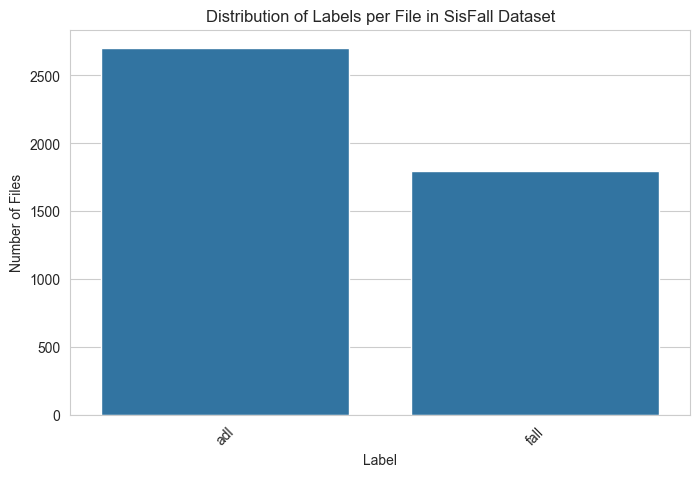

In [78]:
# Check the distribution of labels per file
file_label_counts = sisfall_data[['filename', 'label']].drop_duplicates()['label'].value_counts()

# Print the distribution of labels per file
print("Distribution of labels per file:")
print(file_label_counts)

# Print the percentage of each label
total_files = file_label_counts.sum()
for label, count in file_label_counts.items():
    percentage = (count / total_files) * 100
    print(f"{label}: {count} files ({percentage:.2f}%)")

plt.figure(figsize=(8, 5))
sns.barplot(x=file_label_counts.index, y=file_label_counts.values)
plt.title('Distribution of Labels per File in SisFall Dataset')
plt.xlabel('Label')
plt.ylabel('Number of Files')
plt.xticks(rotation=45)
plt.show()

Distribution of labels:
label
adl     10465215
fall     5393714
Name: count, dtype: int64
adl: 10465215 samples (65.99%)
fall: 5393714 samples (34.01%)


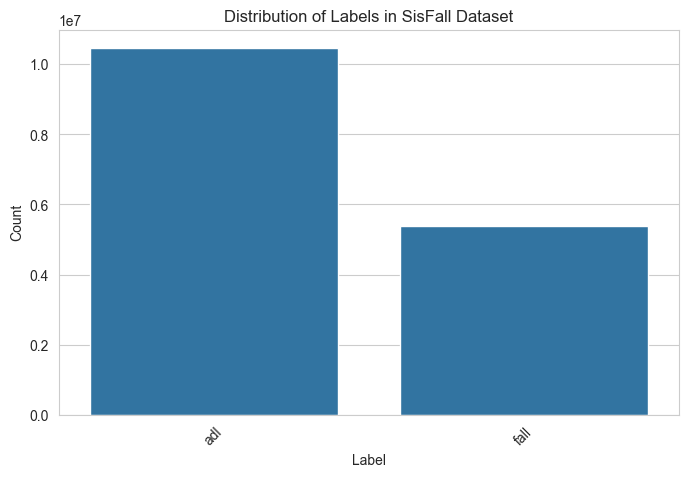

In [79]:
# Check the distribution of labels
label_counts = sisfall_data['label'].value_counts()

# Print the distribution of labels
print("Distribution of labels:")
print(label_counts)

# Print the percentage of each label
total_samples = label_counts.sum()
for label, count in label_counts.items():
    percentage = (count / total_samples) * 100
    print(f"{label}: {count} samples ({percentage:.2f}%)")

plt.figure(figsize=(8, 5))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Distribution of Labels in SisFall Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [80]:
# Check for missing values
missing_values = sisfall_data.isnull().sum()
missing_values[missing_values > 0]

Series([], dtype: int64)

In [81]:
# Check the data types of the columns
sisfall_data.dtypes

accel_adxl345_x     float64
accel_adxl345_y     float64
accel_adxl345_z     float64
gyro_itg3200_x      float64
gyro_itg3200_y      float64
gyro_itg3200_z      float64
accel_mma8451q_x    float64
accel_mma8451q_y    float64
accel_mma8451q_z    float64
label                object
filename             object
subject              object
dtype: object

In [82]:
# Check the summary statistics of the dataset
sisfall_data.describe()

,accel_adxl345_x,accel_adxl345_y,accel_adxl345_z,gyro_itg3200_x,gyro_itg3200_y,gyro_itg3200_z,accel_mma8451q_x,accel_mma8451q_y,accel_mma8451q_z
count,1.585893e+07,1.585893e+07,1.585893e+07,1.585893e+07,1.585893e+07,1.585893e+07,1.585893e+07,1.585893e+07,1.585893e+07
mean,-4.832774e-03,-6.982077e-01,-1.083005e-01,-5.929070e-01,2.146792e+00,-2.725448e-01,-1.844993e-02,-6.840996e-01,-5.797724e-02
std,4.101803e-01,5.856842e-01,4.878332e-01,3.606290e+01,2.987677e+01,2.430040e+01,3.990512e-01,5.690894e-01,4.942543e-01
min,-1.600000e+01,-1.600000e+01,-1.600000e+01,-1.971619e+03,-9.454956e+02,-8.026123e+02,-8.000000e+00,-8.000000e+00,-8.000000e+00
25%,-8.593750e-02,-9.882812e-01,-3.593750e-01,-4.638672e+00,-1.098633e+00,-2.014160e+00,-9.472656e-02,-9.667969e-01,-3.095703e-01
50%,7.812500e-03,-8.984375e-01,-1.210938e-01,-6.713867e-01,2.319336e+00,-3.051758e-01,9.765625e-04,-8.837891e-01,-6.640625e-02
75%,1.015625e-01,-2.109375e-01,1.289062e-01,3.967285e+00,5.737305e+00,1.403809e+00,8.007812e-02,-2.041016e-01,1.806641e-01
max,1.599219e+01,1.598438e+01,1.598047e+01,1.999939e+03,9.655151e+02,8.421631e+02,7.999023e+00,7.999023e+00,7.999023e+00


In [83]:
# Visualize the distribution of accelerometer and gyroscope data
def plot_sensor_data_distribution(data, sensor):
    plt.figure(figsize=(12, 6))
    sns.histplot(data[sensor], bins=50, kde=True)
    plt.title(f'Distribution of {sensor} Data')
    plt.xlabel(sensor)
    plt.ylabel('Frequency')
    plt.show()


# Plot accelerometer data
# accel_columns = [col for col in sisfall_data.columns if 'accel' in col]
# for col in accel_columns:
#     plot_sensor_data_distribution(sisfall_data, col)
# 
# # Plot gyroscope data
# gyro_columns = [col for col in sisfall_data.columns if 'gyro' in col]
# for col in gyro_columns:
#     plot_sensor_data_distribution(sisfall_data, col)

In [84]:
# Visualize the previous plots as subplots
def plot_sensor_data_distribution_subplots(data, sensor_columns):
    num_columns = len(sensor_columns)
    num_rows = (num_columns + 1) // 3

    fig, axes = plt.subplots(num_rows, 3, figsize=(12, 6 * num_rows))
    axes = axes.flatten()

    for i, col in enumerate(sensor_columns):
        sns.histplot(data[col], bins=50, kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col} Data')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()
    
# # Plot accelerometer data
# plot_sensor_data_distribution_subplots(sisfall_data, accel_columns)
# 
# # Plot gyroscope data
# plot_sensor_data_distribution_subplots(sisfall_data, gyro_columns)

In [85]:
# Visualize the time series data for a sample fall and ADL
def plot_time_series(data, label):
    plt.figure(figsize=(15, 8))
    for col in data.columns:
        if 'accel' in col or 'gyro' in col:
            plt.plot(data[col], label=col)
    plt.title(f'Time Series Data for {label}')
    plt.xlabel('Time')
    plt.ylabel('Sensor Value')
    plt.legend()
    plt.show()


# # Plot time series for a sample fall
# fall_sample = sisfall_data[sisfall_data['label'] == 'fall'].iloc[0]
# fall_data = sisfall_data[sisfall_data['filename'] == fall_sample['filename']]
# plot_time_series(fall_data, 'Fall Sample')
# 
# # Plot time series for a sample ADL
# adl_sample = sisfall_data[sisfall_data['label'] == 'adl'].iloc[0]
# adl_data = sisfall_data[sisfall_data['filename'] == adl_sample['filename']]
# plot_time_series(adl_data, 'ADL Sample')

## Reducing the dataset

The SisFall dataset is quite large, with many samples. To speed up the training process, we can reduce the dataset size by selecting a subset of samples. In this case, we want a selection that preserves the original distribution of fall and ADL recordings across subjects. The full dataset consists of:

- 23 adult subjects (SA01–SA23), each with ~154 files
- 15 elderly subjects (SE01–SE15), mostly with ~59 files (except SE06 with 154)

The global fall-to-ADL ratio is approximately 40% fall and 60% ADL. To preserve this behavior in a smaller subset, we can choose:

- A few adults with complete fall + ADL scenarios
- A mix of elderly participants who mostly simulate ADLs

A good selection could be:

SA01 (154 files)
SA02 (154 files)
SA03 (154 files)
SA04 (154 files)
SA05 (154 files)
SE01 (59 files)
SE02 (59 files)
SE03 (59 files)
SE06 (154 files)
SE07 (59 files)

In [86]:
# Select the subjects to keep
subjects_to_keep = [
    'SA01', 'SA02', 'SA03', 'SA05', 'SA06',
    'SE01', 'SE02', 'SE03', 'SE06', 'SE07'
]

# Create a new DataFrame with the selected subjects
reduced_dataset = sisfall_data[sisfall_data['subject'].isin(subjects_to_keep)].copy()

# Reset the index
reduced_dataset.reset_index(drop=True, inplace=True)

# Save the reduced dataset to a CSV file
reduced_dataset.to_csv('sisfall_reduced_dataset.csv', index=False)

Distribution of labels per file:
label
adl     699
fall    450
Name: count, dtype: int64
adl: 699 files (60.84%)
fall: 450 files (39.16%)


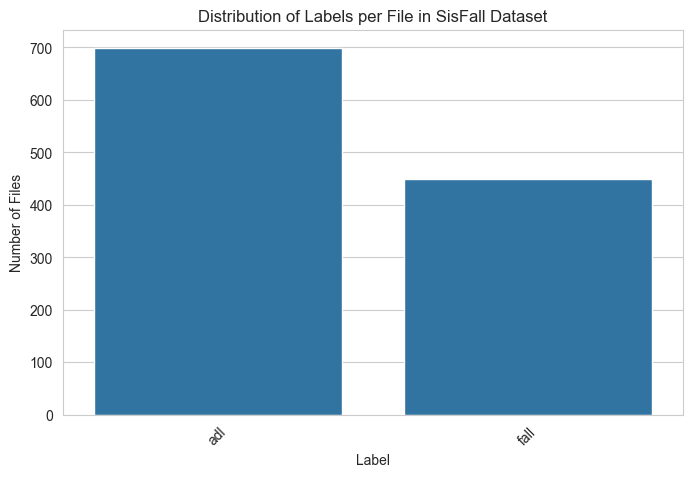

In [87]:
# Check the distribution of labels per file
file_label_counts = reduced_dataset[['filename', 'label']].drop_duplicates()['label'].value_counts()

# Print the distribution of labels per file
print("Distribution of labels per file:")
print(file_label_counts)

# Print the percentage of each label
total_files = file_label_counts.sum()
for label, count in file_label_counts.items():
    percentage = (count / total_files) * 100
    print(f"{label}: {count} files ({percentage:.2f}%)")

plt.figure(figsize=(8, 5))
sns.barplot(x=file_label_counts.index, y=file_label_counts.values)
plt.title('Distribution of Labels per File in SisFall Dataset')
plt.xlabel('Label')
plt.ylabel('Number of Files')
plt.xticks(rotation=45)
plt.show()

Distribution of labels:
label
adl     2751235
fall    1349977
Name: count, dtype: int64
adl: 2751235 samples (67.08%)
fall: 1349977 samples (32.92%)


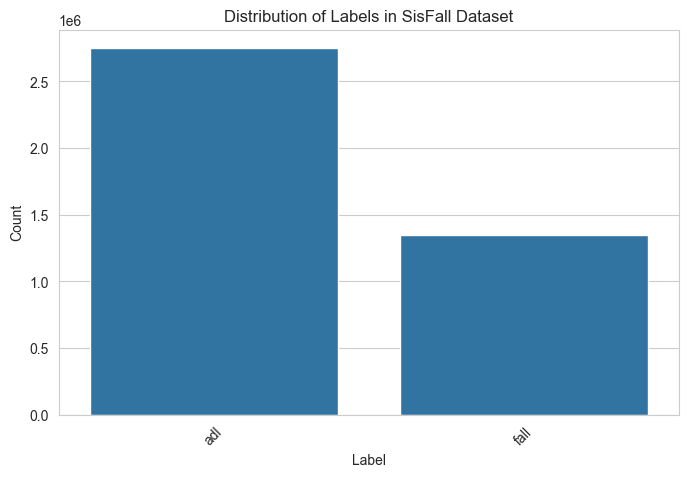

In [88]:
# Check the distribution of labels
label_counts = reduced_dataset['label'].value_counts()

# Print the distribution of labels
print("Distribution of labels:")
print(label_counts)

# Print the percentage of each label
total_samples = label_counts.sum()
for label, count in label_counts.items():
    percentage = (count / total_samples) * 100
    print(f"{label}: {count} samples ({percentage:.2f}%)")

plt.figure(figsize=(8, 5))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Distribution of Labels in SisFall Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()